## Introduction

In this notebook, we’ll do a exploration of the [PLDM-dataset](https://github.com/SnorkerHeng/PLD-UAV). We’ll look at storing of the data. Then we’ll train a model to see how well we can predict the labels. I used this [tutorial](https://walkwithfastai.com/Segmentation) for segmentation.

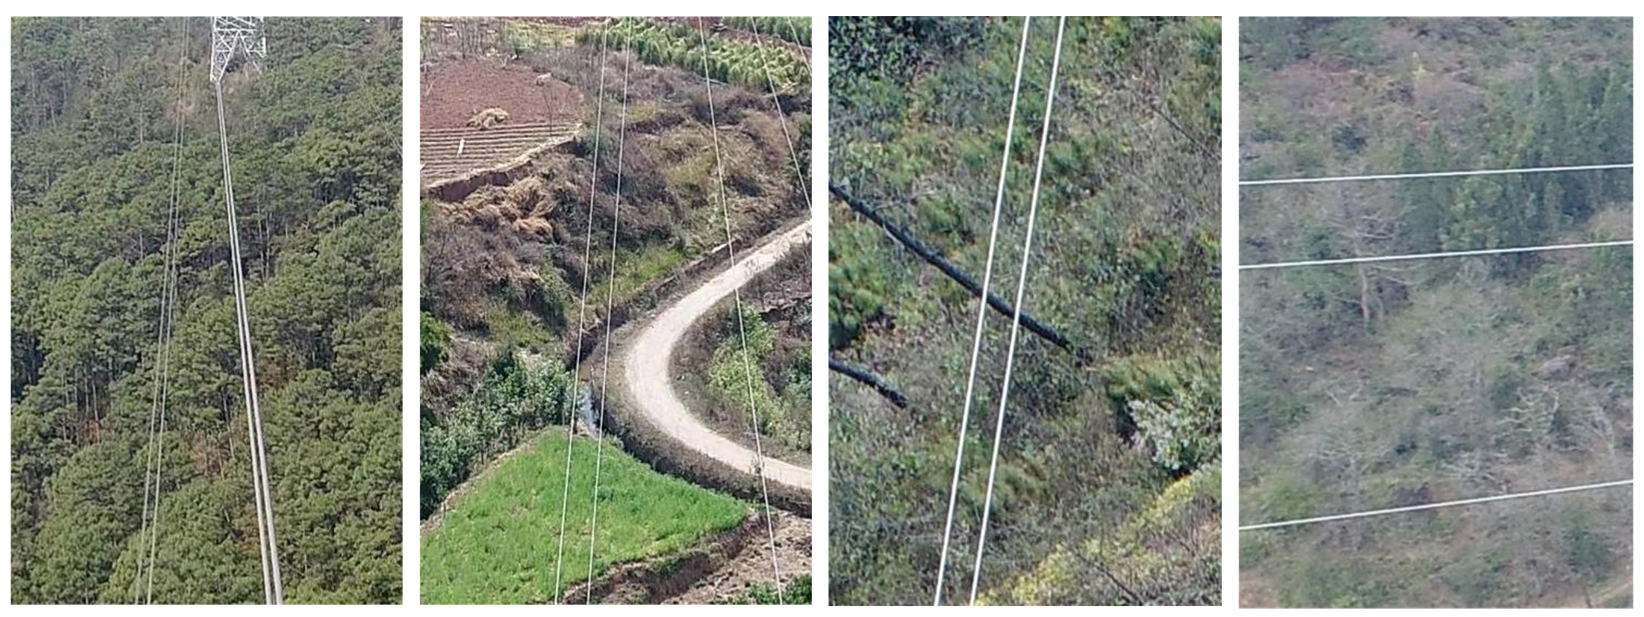

# Setup

In [171]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [172]:
#!pip install gradio
#pip install --upgrade transformers
#pip install --upgrade huggingface_hub

In [173]:
from fastcore.xtras import Path

from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_flat_cos

from fastai.data.block import DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize

from fastai.layers import Mish
from fastai.losses import BaseLoss
from fastai.optimizer import ranger

from fastai.torch_core import tensor

from fastai.vision.all import *
from fastai.vision.augment import aug_transforms
from fastai.vision.core import PILImage, PILMask
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats
from fastai.vision.learner import unet_learner


from PIL import Image
import numpy as np

from pathlib import Path

from scipy.io import loadmat

from torch import nn
from torchvision.models.resnet import resnet34

import torch
import torch.nn.functional as F

#import gradio as gr

import cv2 as cv2
from matplotlib import pyplot as plt

# Download data

The data is available on [GitHub](https://github.com/SnorkerHeng/PLD-UAV).

# Inspect dataset

For now, I only used PLDM(Power lines dataset mountain) dataset, but for further work I would also use PLDU(Power lines dataset urban) dataset where I could compare the different result, if the environment had any impact.

In [174]:
os.listdir('/kaggle/input')

['pldm-dataset', 'pldu-dataset']

In [175]:
#both training,test and pre-computed set
os.listdir('/kaggle/input/pldm-dataset/PLDM Dataset')

['test_gt', 'test.lst', 'test', 'train_pair.lst', 'train']

In [176]:
#example of img-filenames
os.listdir('/kaggle/input/pldm-dataset/PLDM Dataset/test')

['212.jpg',
 '239.jpg',
 '109.jpg',
 '149.jpg',
 '187.jpg',
 '8.jpg',
 '237.jpg',
 '273.jpg',
 '85.jpg',
 '176.jpg',
 '38.jpg',
 '33.jpg',
 '62.jpg',
 '278.jpg',
 '124.jpg',
 '247.jpg',
 '221.jpg',
 '57.jpg',
 '99.jpg',
 '46.jpg',
 '79.jpg',
 '285.jpg',
 '214.jpg',
 '252.jpg',
 '159.jpg',
 '121.jpg',
 '28.jpg',
 '173.jpg',
 '199.jpg',
 '142.jpg',
 '180.jpg',
 '104.jpg',
 '24.jpg',
 '155.jpg',
 '195.jpg',
 '43.jpg',
 '228.jpg',
 '53.jpg',
 '164.jpg',
 '219.jpg',
 '12.jpg',
 '70.jpg',
 '4.jpg',
 '93.jpg',
 '18.jpg',
 '268.jpg',
 '116.jpg',
 '66.jpg',
 '134.jpg',
 '249.jpg']

In [177]:
test_path = DATA = Path('/kaggle/input/pldm-dataset/PLDM Dataset/test')
test_img = list(test_path.glob('*'))[1]
test_img

Path('/kaggle/input/pldm-dataset/PLDM Dataset/test/239.jpg')

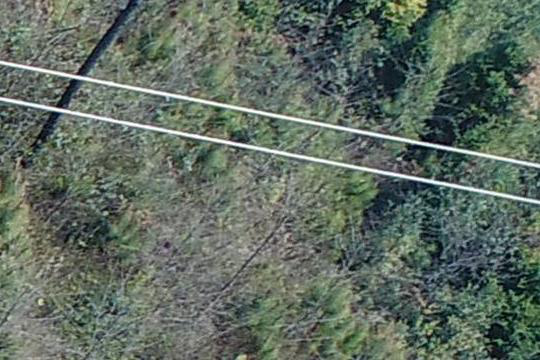

In [178]:
img = load_image(test_img)
img

In [179]:
# train data is devided by different scales
os.listdir('/kaggle/input/pldm-dataset/PLDM Dataset/train')

['aug_gt_scale_0.5',
 'aug_data',
 'aug_data_scale_1.5',
 'aug_gt_scale_1.5',
 'aug_gt',
 'aug_data_scale_0.5']

In [180]:
# The naming of these files represents the rotation as shown in the next cells
os.listdir('/kaggle/input/pldm-dataset/PLDM Dataset/train/aug_data')

['45.0_0',
 '90.0_0',
 '270.0_0',
 '90.0_1',
 '180.0_0',
 '180.0_1',
 '315.0_0',
 '270.0_1',
 '135.0_1',
 '225.0_1',
 '45.0_1',
 '0.0_1',
 '135.0_0',
 '225.0_0',
 '315.0_1',
 '0.0_0']

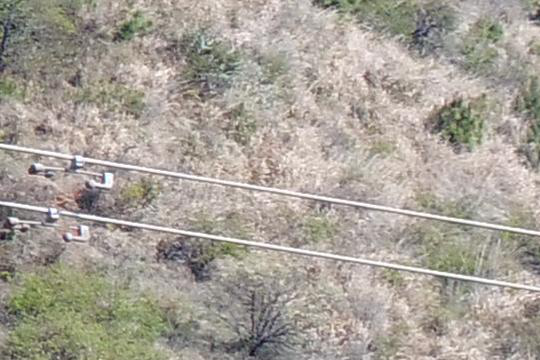

In [181]:
img = load_image(Path('/kaggle/input/pldm-dataset/PLDM Dataset/train/aug_data/0.0_0/1.jpg'))
img

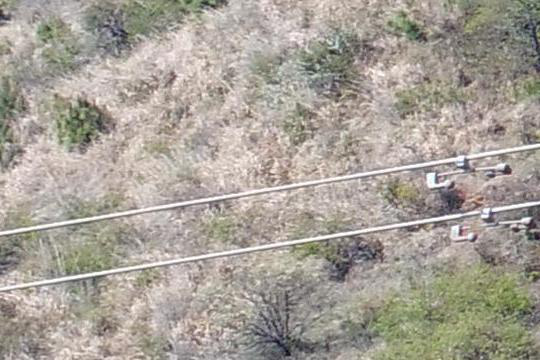

In [182]:
img = load_image(Path('/kaggle/input/pldm-dataset/PLDM Dataset/train/aug_data/0.0_1/1.jpg'))
img

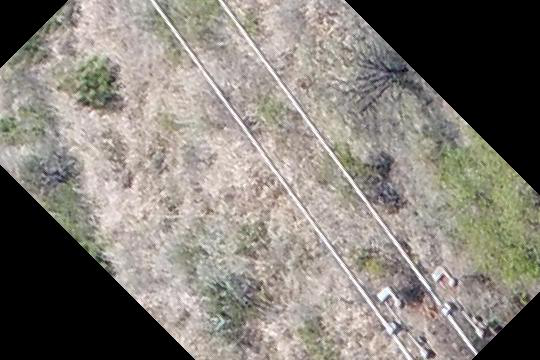

In [183]:
img = load_image(Path('/kaggle/input/pldm-dataset/PLDM Dataset/train/aug_data/135.0_0/1.jpg'))
img

In [184]:
path_im = Path('/kaggle/input/pldm-dataset/PLDM Dataset/train/aug_data/0.0_0')
path_msk = Path('/kaggle/input/pldm-dataset/PLDM Dataset/train/aug_gt/0.0_0')

In [185]:
#Tried to understand the mat-files,but did not understand enough to use them
pldm_mat = '/kaggle/input/pldm-dataset/PLDM Dataset/test_gt/104.mat'


pldm_data = loadmat(pldm_mat)

In [186]:
pldm_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Oct 25 19:46:13 2018',
 '__version__': '1.0',
 '__globals__': [],
 'groundTruth': array([[array([[(array([[0, 0, 0, ..., 0, 0, 0],
                        [0, 0, 0, ..., 0, 0, 0],
                        [0, 0, 0, ..., 0, 0, 0],
                        ...,
                        [0, 0, 0, ..., 0, 0, 0],
                        [0, 0, 0, ..., 0, 0, 0],
                        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),)]],
               dtype=[('Boundaries', 'O')])                        ]],
       dtype=object)}

In [187]:
variable_names = pldm_data.keys(); variable_names

dict_keys(['__header__', '__version__', '__globals__', 'groundTruth'])

In [188]:
pldm_data['groundTruth'][0][0][0][0]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),)

In [189]:
fnames = get_image_files(path_im)
msk_names = get_image_files(path_msk)

In [190]:
get_msk = lambda o: path_msk/f'{o.stem}.png'

In [191]:
fnames[10]

Path('/kaggle/input/pldm-dataset/PLDM Dataset/train/aug_data/0.0_0/71.jpg')

<AxesSubplot:>

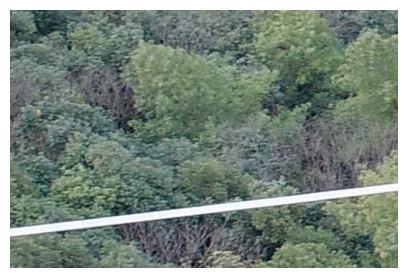

In [192]:
img_fn = fnames[10]
img = PILImage.create(img_fn)
img.show(figsize=(5,5))

<AxesSubplot:>

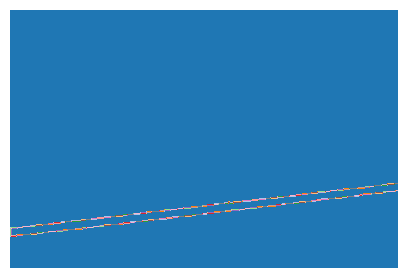

In [193]:
# printed the precomputed masks
msk = PILMask.create(get_msk(img_fn))
msk.show(figsize=(5,5), alpha=1)

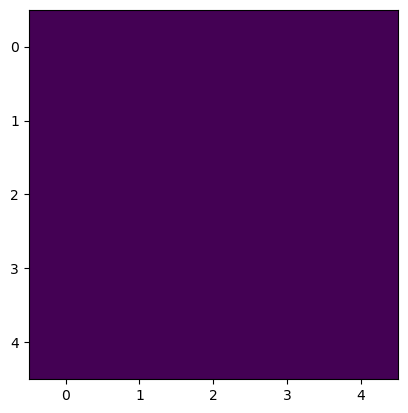

In [194]:
# Masks
# Could have done it manually with label stuido, but did not prioritize to use time on that
# One example where I tired to fill the masks without succeding

mask = PILMask.create(get_msk(img_fn))

mask = torch.Tensor(np.array(mask)[:,0] > 0.5).unsqueeze(0).unsqueeze(0)

kernel = torch.ones((1, 1, 5,364))
mask_dilated = F.conv2d(mask, kernel, padding=4).clamp(min=0, max=1).squeeze(0).squeeze(0)

mask_dilated = (mask_dilated * 255).numpy().astype('uint8')
mask_dilated = Image.fromarray(mask_dilated)

plt.imshow(mask_dilated)
plt.show()


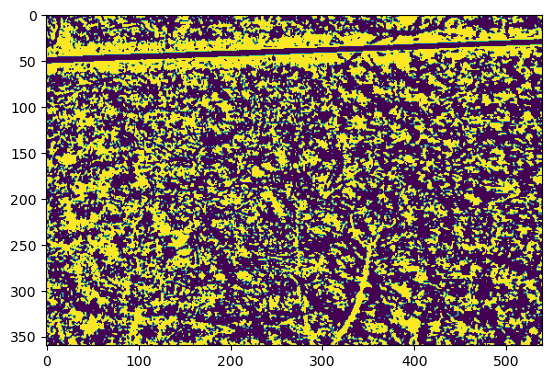

In [195]:
#Another exampl - masks
im = cv2.imread("/kaggle/input/pldm-dataset/PLDM Dataset/test/104.jpg",0)
plt.imshow(im)
thresh = cv2.adaptiveThreshold(im,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY_INV,31,3)
plt.imshow(thresh)

In [196]:
tensor(msk)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)

In [197]:
codes= np.array(["PowerLines", "Sky"])
codes

array(['PowerLines', 'Sky'], dtype='<U10')

In [198]:
data = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   get_y=get_msk,
                   item_tfms = Resize(224),
                   batch_tfms=[IntToFloatTensor(div_mask=255)])

# Create dataloaders

In [199]:
path = Path('/kaggle/input/pldm-dataset/PLDM Dataset')

image_path = path/'train/aug_data/0.0_0'

dls = data.dataloaders(image_path, bs=8)
#dls= SegmentationDataLoaders.from_label_func(image_path,bs=8,
 #                                            fnames=fnames,
  #                                           label_func=get_msk,
   #                                          item_tfms = Resize(224),
    #                                         batch_tfms=[IntToFloatTensor(div_mask=255)])

#def fill_mask(mask):
 #   mask_binary = (mask > 0.5).float()
  #  mask_blur = mask_binary.gaussian_blur(kernel_size=7)
   # mask_filled = torch.where(mask > 0.5, mask, mask_blur)
    
    #return mask_filled

#dls = dls.map_masks(fill_mask)

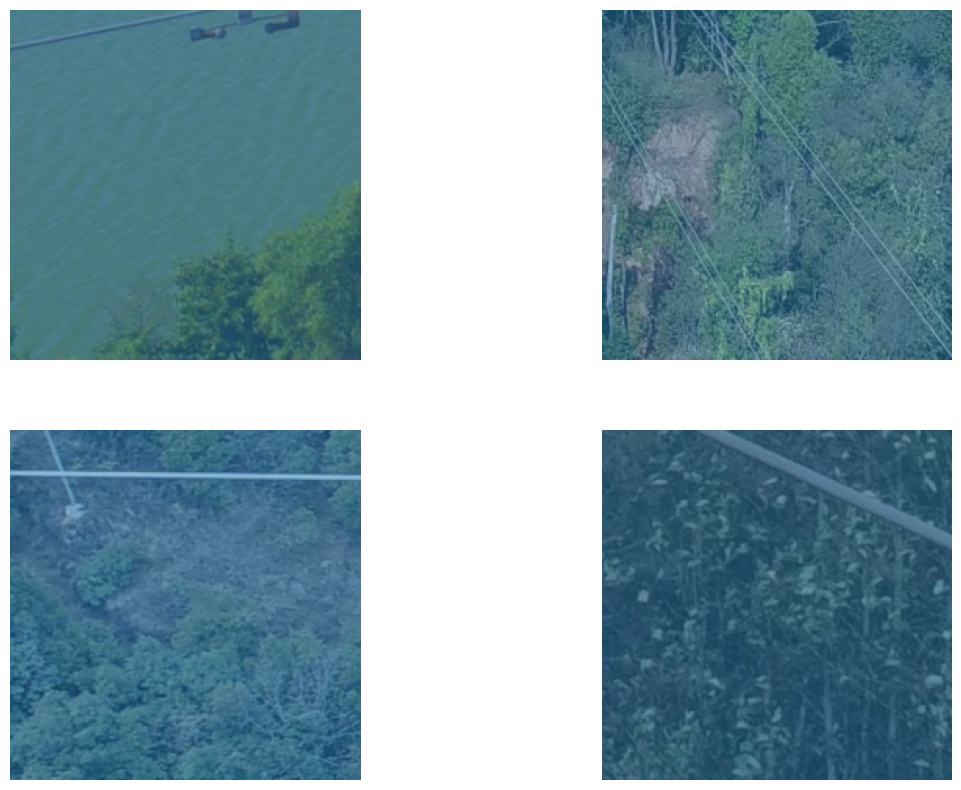

In [200]:
dls.show_batch(max_n=4, vmin=1, vmax=30, figsize=(14,10))

In [201]:
dls.vocab = codes
name2id = {v:k for k,v in enumerate(codes)}

In [202]:
name2id

{'PowerLines': 0, 'Sky': 1}

In [203]:
void_code = name2id['Sky']

In [204]:
def acc_pldm(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

In [205]:
opt = ranger

# Create learner

In [206]:
learn = unet_learner(dls, resnet34, metrics=acc_pldm, self_attention=True, act_cls=Mish, opt_func=opt)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [207]:
learn.summary()

DynamicUnet (Input shape: 8 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 64 x 112 x 112  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     8 x 64 x 56 x 56    
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

SuggestedLRs(valley=4.365158383734524e-05)

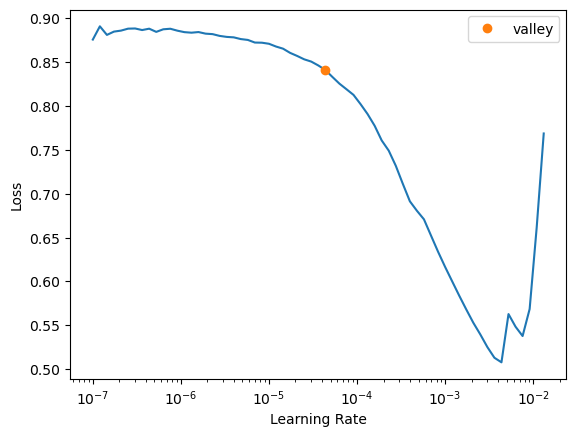

In [208]:
learn.lr_find()

In [209]:
lr = 1e-4
learn.fit_flat_cos(8, slice(lr))

In [210]:
learn.save('powerLines')
learn.load('powerLines');

In [211]:
#save the model to use for huggingface(further work)
learn.export('model.pkl')

PicklingError: Can't pickle <function <lambda> at 0x7567186708c0>: attribute lookup <lambda> on __main__ failed

In [212]:
learn.show_results(max_n=4, figsize=(12,6))

ValueError: This DataLoader does not contain any batches

ValueError: This DataLoader does not contain any batches

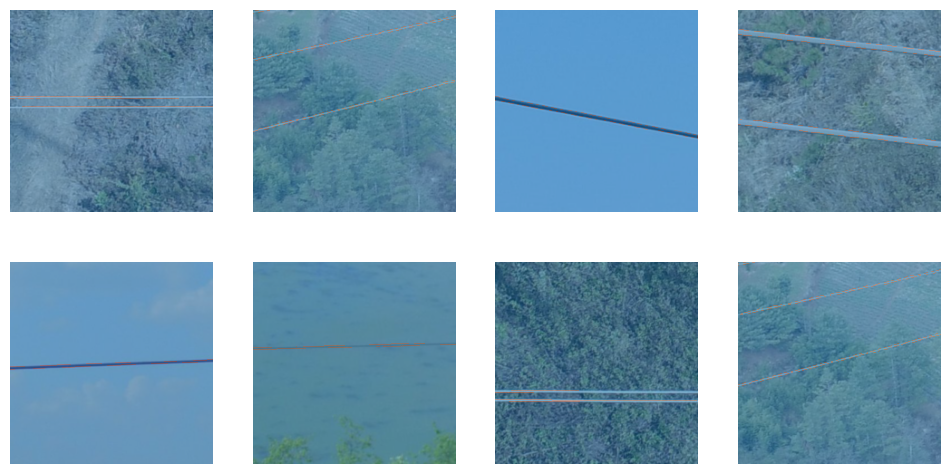

In [213]:
dls.show_batch()

# use learn.show_results() to visualize the model's predictions on the same batch of data
learn.show_results(max_n=4, figsize=(12,6))

In [214]:
print(len(dls.train))

23


# Ideas to improve the performance

The model is quite poor, possible because of the bad masks. As mentioned earlier I would do segmentation on both PLDM and PLDU and compare them. When it comes to the whole process, I would look closer at the data augmentation, use transfer learning and experiment with different approaches . The masks were not good, the results were some dots, but ideally they would be a line with fill which would be an improvement. It may not be that simple since it often is not easy to tell background and power lines appart 

# Gradio app - draft

In [ ]:
def segment(image):
    msk = PILMask.create(get_msk(image))
    msk.show(figsize=(5,5), alpha=1)

gr.Interface(fn=segment, inputs="image", outputs="image").launch()


# Test PLDU - dataset

In [215]:
path2_im = Path('/kaggle/input/pldu-dataset/PLDU Dataset/train/aug_data/0.0_0')
path2_msk = Path('/kaggle/input/pldu-dataset/PLDU Dataset/train/aug_gt/0.0_0')

In [216]:
fnames2 = get_image_files(path2_im)
msk_names2 = get_image_files(path2_msk)

In [217]:
get_msk = lambda o: path2_msk/f'{o.stem}.png'

In [218]:
data = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   get_y=get_msk,
                   item_tfms = Resize(224),
                   batch_tfms=[IntToFloatTensor(div_mask=255)])

In [219]:
path2 = Path('/kaggle/input/pldu-dataset/PLDU Dataset')

image_path2 = path2/'train/aug_data/0.0_0'

dls2 = data.dataloaders(image_path2, bs=8)

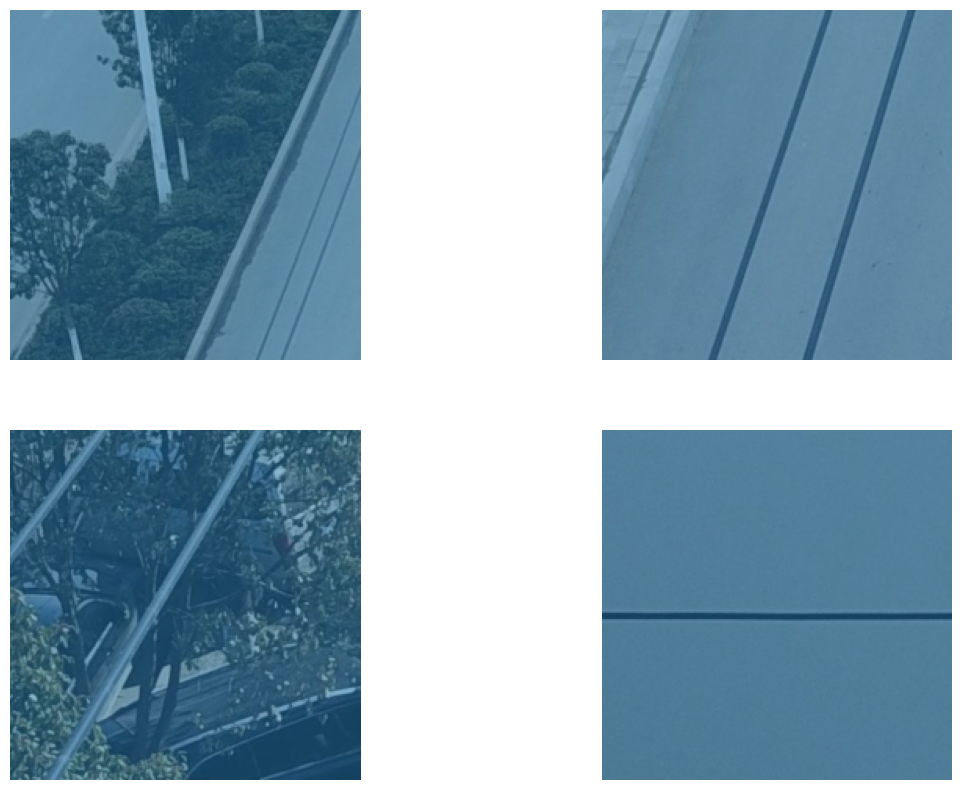

In [220]:
dls2.show_batch(max_n=4, vmin=1, vmax=30, figsize=(14,10))

In [221]:
learn2 = unet_learner(dls2, resnet34, metrics=acc_pldm, self_attention=True, act_cls=Mish, opt_func=opt)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=6.30957365501672e-05)

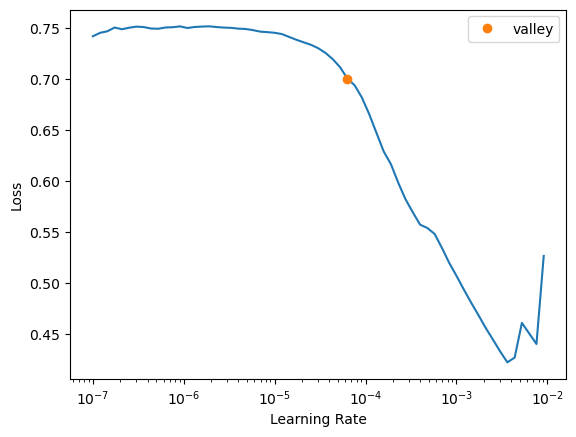

In [222]:
learn2.lr_find()

In [223]:
lr2 = 1e-5
learn2.fit_flat_cos(8, slice(lr2))

Tried to train both PLDM and PLDU dataset to compare. From the result, we can see that they were pretty similare with low valid loss and training loss even though it does not work as expected